# CAN Workshop- LFADS demo in pytorch

## Import necessary modules

In [1]:
%matplotlib inline

import torch
import torchvision
np = torch._np
import matplotlib.pyplot as plt

import os
import yaml
import math
from lfads_sim import LFADS_Net
from utils import read_data, load_parameters, save_parameters
import scipy.io
# plt.style.use('dark_background')
import shutil
path = './models_sim'
if os.path.isdir(path): 
    shutil.rmtree(path)

In [2]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


## Load or Generate Data 

In [3]:
Time = 20
"""all_time =2500
start_time = 0
neuron_num = 30
datax = scipy.io.loadmat("spike30_sim_3000.mat")
y_data = datax["spike30_sim_3000"][start_time:all_time,:]
traj = scipy.io.loadmat("trj30_sim_3000.mat")
traj = traj["trj30_sim_3000"][start_time:all_time,:]"""
good_neuron_id = [0,1,5,9,11,14,19,21,35,36]
neuron_num = len(good_neuron_id)
start_time = 0
all_time = 3000
datax = scipy.io.loadmat("spike40_cu_3000.mat")
traj = scipy.io.loadmat("trj40_cu_3000.mat")
traj = traj["trj40_cu_3000"][:,start_time:all_time]
y_data0 = datax["spike40_cu_3000"][:,start_time:all_time]
y_data = np.zeros((all_time-start_time,neuron_num))
for i in range(neuron_num):
    a = good_neuron_id[i]
    y_data[:,i] = y_data0[:,a]
NRep=int((all_time-start_time)/Time)
output = np.zeros((NRep,Time,neuron_num))
#print(y_data.shape)
#for i in range(all_time-start_time):
#    for j in range(neuron_num):
#        if y_data[i][j] > 20:
#            y_data[i][j] = 20
for i in range(NRep):
    output[i,:,:] = y_data[Time*i:Time*(i+1),:]
output = output.astype('float32')
output = torch.Tensor(output).to(device)
print(output.shape)
output_valid = output.detach().clone()

torch.Size([150, 20, 10])


## View example Ground Truth Firing Rates

(20, 10)


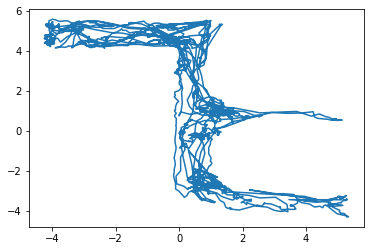

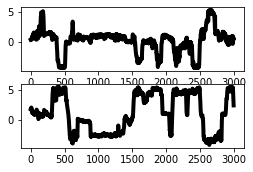

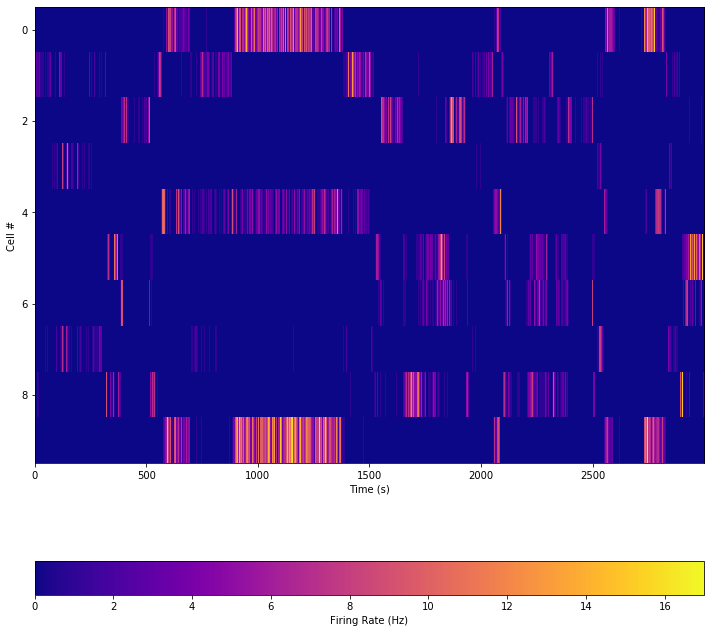

In [4]:
train_ds      = torch.utils.data.TensorDataset(output)
valid_ds      = torch.utils.data.TensorDataset(output)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)
plt.figure(figsize = (12,12))
plt.imshow(y_data.T, cmap=plt.cm.plasma,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')

<IPython.core.display.Javascript object>


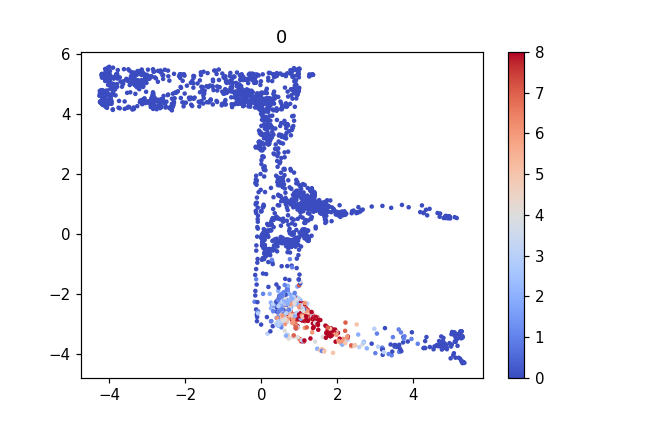

<IPython.core.display.Javascript object>


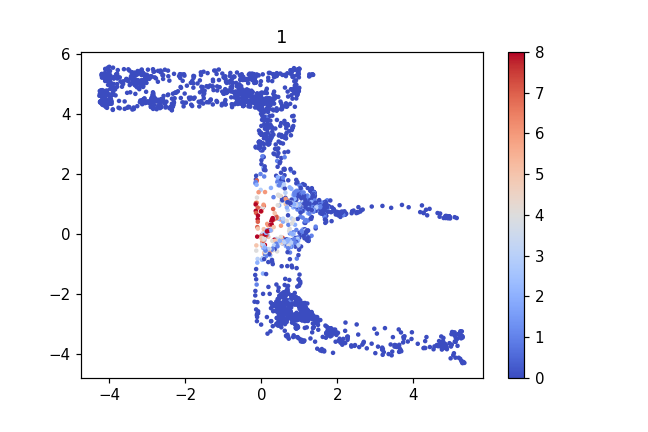

<IPython.core.display.Javascript object>


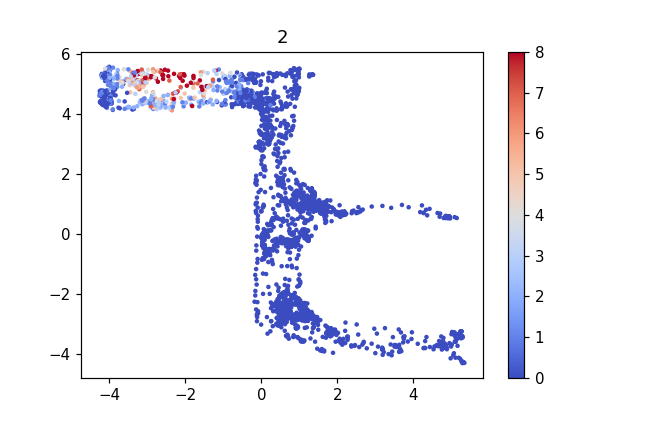

<IPython.core.display.Javascript object>


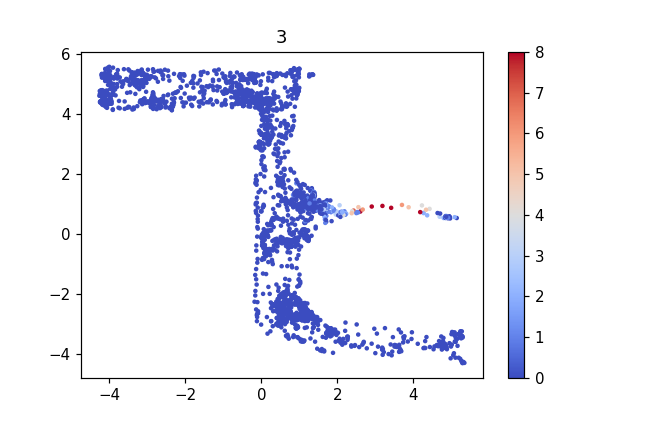

<IPython.core.display.Javascript object>


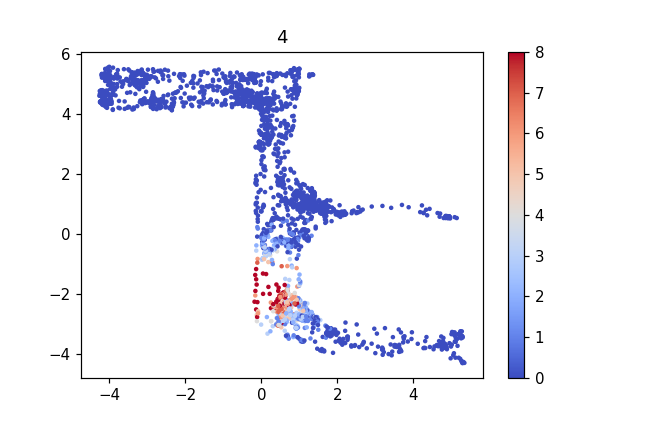

<IPython.core.display.Javascript object>


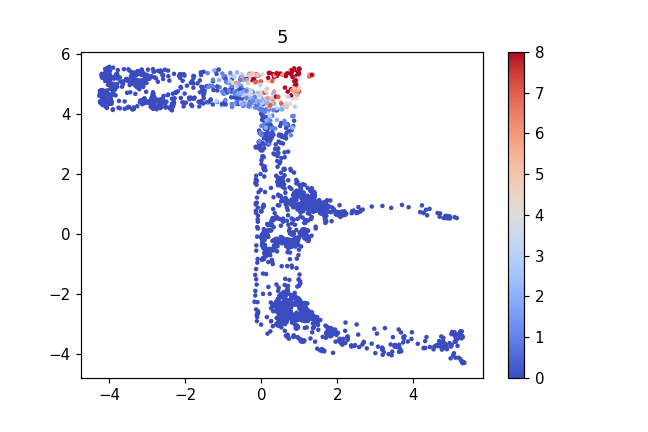

<IPython.core.display.Javascript object>


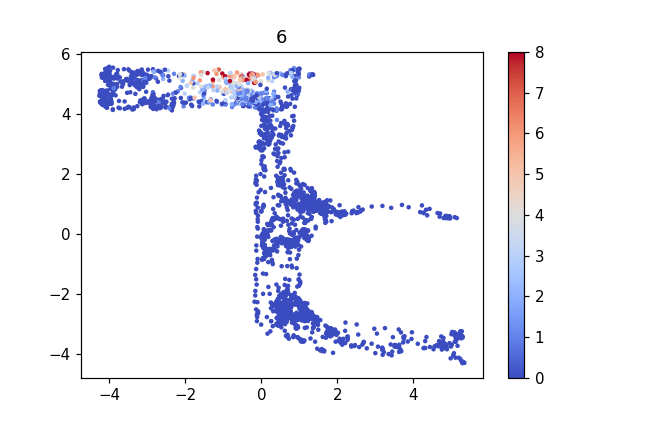

<IPython.core.display.Javascript object>


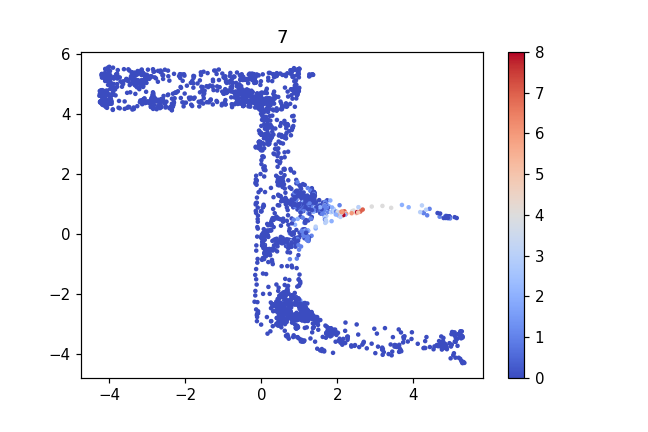

<IPython.core.display.Javascript object>


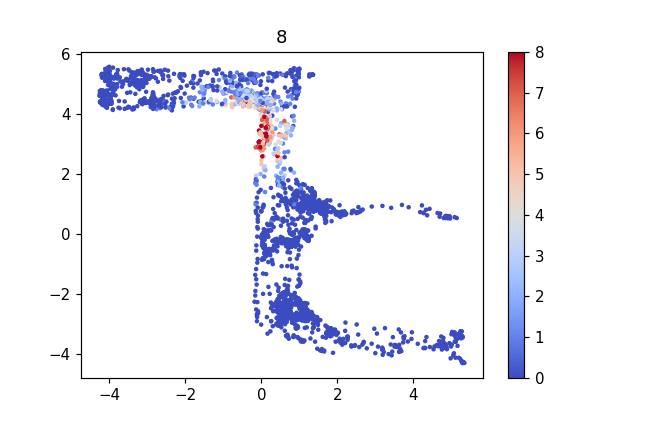

<IPython.core.display.Javascript object>


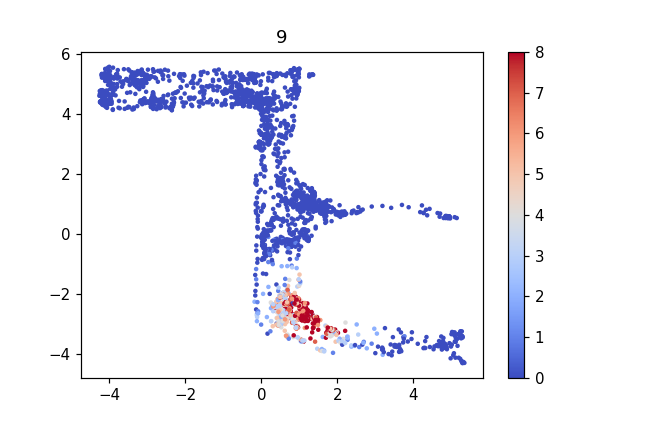

In [17]:
for i in range(neuron_num):
    fig, ax = plt.subplots()
    mappable = ax.scatter(traj[:,0], traj[:,1], c=y_data[:,i] ,cmap='coolwarm',vmin=0,vmax=8,s=4)
    fig.colorbar(mappable)
    plt.title(i)
    plt.show()
#fig.savefig("img.png")

## LFADS Schema
<img src='lfads_schema.png' width=800 align=left>

## Load model hyperparameters 

In [6]:
hyperparams = load_parameters('./parameters_sim.yaml')
save_parameters(hyperparams)
hyperparams

{'dataset_name': 'chaotic_rnn',
 'run_name': 'demo',
 'g_dim': 30,
 'u_dim': 30,
 'factors_dim': 2,
 'g0_encoder_dim': 30,
 'c_encoder_dim': 30,
 'controller_dim': 30,
 'g0_prior_kappa': 0.1,
 'u_prior_kappa': 0.1,
 'keep_prob': 0.95,
 'clip_val': 5.0,
 'max_norm': 200,
 'learning_rate': 0.01,
 'learning_rate_min': 1e-05,
 'learning_rate_decay': 0.9,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'scheduler_cooldown': 6,
 'kl_weight_schedule_start': 0,
 'kl_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'l2_weight_schedule_dur': 2000,
 'epsilon': 0.1,
 'betas': (0.9, 0.99),
 'l2_gen_scale': 2000,
 'l2_con_scale': 0}

## Instantiate LFADS model

In [7]:
model = LFADS_Net(inputs_dim = neuron_num, T = Time, dt = 1, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 267


#### Pick up where you left off (if you have a recent save) 

In [8]:
# model.load_checkpoint('recent')
batch_size = 20
"""tt = np.empty((3000,2))
for k in range(10):
    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(t[90].shape)
    for i in range(batch_size):
        for j in range(100):
            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()
plt.figure()
plt.plot(tt)"""

"tt = np.empty((3000,2))\nfor k in range(10):\n    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])\n    #print(t[90].shape)\n    for i in range(batch_size):\n        for j in range(100):\n            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()\nplt.figure()\nplt.plot(tt)"

## Fit model

Rule of thumb: You can usually see good fit after 200 epochs (~30 mins runtime on Thinkpad GPU, ~2.5 hours on CPU), but to see good inference of perturbation timings need to run for about 800 epochs (~2 hours on Thinkpad GPU).

Beginning training...
Epoch:    1, Step:     8, training loss: 358.657
recon:  324, kl:    10, dir:    0, klf:    0, klw:    0
Epoch:    2, Step:    16, training loss: 335.377
recon:  400, kl:    17, dir:    0, klf:    0, klw:    0
Epoch:    3, Step:    24, training loss: 290.131
recon:  276, kl:    20, dir:    0, klf:    0, klw:    0
Epoch:    4, Step:    32, training loss: 240.514
recon:  207, kl:    20, dir:    0, klf:    0, klw:    0
Epoch:    5, Step:    40, training loss: 220.005
recon:  239, kl:    12, dir:    0, klf:    1, klw:    0
Epoch:    6, Step:    48, training loss: 196.397
recon:  166, kl:     8, dir:    0, klf:    2, klw:    0
Epoch:    7, Step:    56, training loss: 171.846
recon:  168, kl:    10, dir:    0, klf:    1, klw:    0
Epoch:    8, Step:    64, training loss: 154.557
recon:  136, kl:    10, dir:    0, klf:    1, klw:    0
Epoch:    9, Step:    72, training loss: 146.087
recon:  142, kl:     8, dir:    0, klf:    1, klw:    0
Epoch:   10, Step:    80, trainin

Epoch:   77, Step:   616, training loss: 115.384
recon:  102, kl:     7, dir:    0, klf:  109, klw:    0
Epoch:   78, Step:   624, training loss: 115.882
recon:  120, kl:     9, dir:    0, klf: 1592, klw:    0
Epoch:   79, Step:   632, training loss: 114.976
recon:  124, kl:    10, dir:    0, klf: 251460, klw:    0
Epoch:   80, Step:   640, training loss: 115.638
recon:  117, kl:     9, dir:    0, klf:  792, klw:    0
Epoch:   81, Step:   648, training loss: 114.271
recon:  107, kl:     7, dir:    0, klf:  154, klw:    0
Epoch:   82, Step:   656, training loss: 115.360
recon:   90, kl:     9, dir:    0, klf: 4755, klw:    0
Epoch:   83, Step:   664, training loss: 113.291
recon:   86, kl:     9, dir:    0, klf: 21859, klw:    0
Epoch:   84, Step:   672, training loss: 114.639
recon:   94, kl:     9, dir:    0, klf: 21011, klw:    0
Epoch:   85, Step:   680, training loss: 117.565
recon:  104, kl:    10, dir:    0, klf: 3531, klw:    0
Learning rate decreased to 0.00531441
Epoch:   86, 

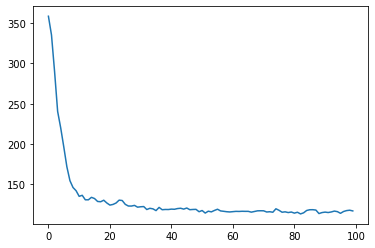

In [9]:
model.fit(train_ds, valid_ds, max_epochs=100, batch_size=batch_size , use_tensorboard=False,
          train_truth=train_ds, valid_truth=valid_ds)

## Load checkpoint with lowest validation error 

torch.Size([150, 20, 10])


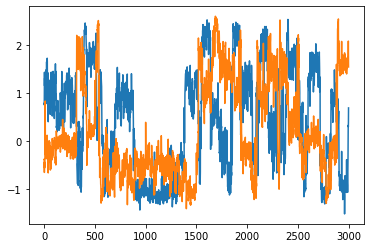

In [10]:
print(output_valid.shape)
#model.plot_factors()
tt = np.zeros(((all_time-start_time),2))
sp = np.zeros(((all_time-start_time),neuron_num))
batch_size=1
gg = int(NRep/batch_size)
import math
def mutual_info(m):
    K=30
    h_y_xw = np.zeros(neuron_num)
    h_y_x = np.zeros(neuron_num)
    T = m.shape[0]
    for n in range(neuron_num):
        for k in range(K):
            h_y_xw_tem = 0
            h_y_x_tem = 0
            for t in range(T):
                h_y_xw_tem += m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k)) * np.log(m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k)))
                h_y_x_tem += m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k))
            h_y_xw[n] += h_y_xw_tem/T
            h_y_x[n] -= h_y_x_tem/T * math.log(h_y_x_tem/T)
            
    return  h_y_xw, h_y_x

for k in range(gg):
    t = model.infer_factors(output_valid[batch_size *k:batch_size *(k+1),:])
    #spi = model.reconstruct(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(spi.shape)
    for i in range(batch_size):
        for j in range(Time):
            tt[(i+batch_size*k)*Time+j,:] = t[i][j].to('cpu').detach().numpy().copy()
            #print(model.mcdropout(output_valid[batch_size *k:batch_size *(k+1),:],np.ones(2),T=10))
            #y_hat = model.mcdropout(output_valid[batch_size *k:batch_size *(k+1),:],np.ones(2),T=10)
            #print(mutual_info(y_hat))
            #obs_mc_mean = y_hat.mean(axis=0)
            #obs_mc_std = y_hat.std(axis=0)
            #print(poisson_entropy(np.round(obs_mc_mean)))
            #for l in range(neuron_num):
                #sp[(i+batch_size*k)*Time+j,l] = spi[j][l]
plt.figure()
plt.plot(tt)

## Plot results summary 

(-2, 20)

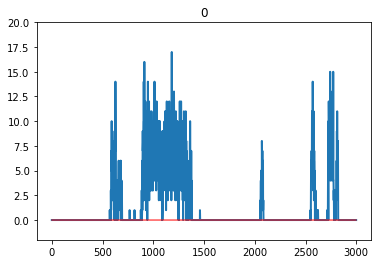

In [11]:
# for i in range(neuron_num):
    plt.figure()
    plt.plot(y_data[:,i], linewidth = 2)
    plt.plot(sp[:,i],'r',linewidth = 1)
    plt.title(i)
    plt.ylim(-2,20)

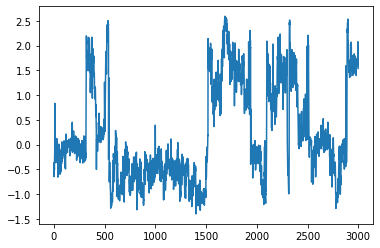

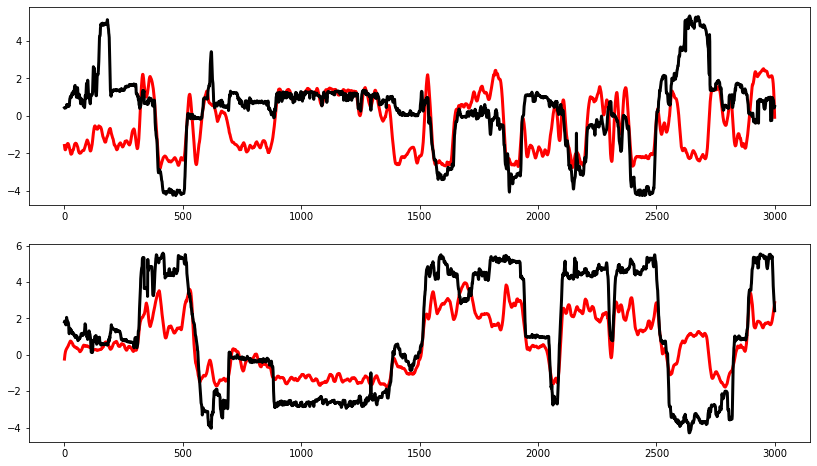

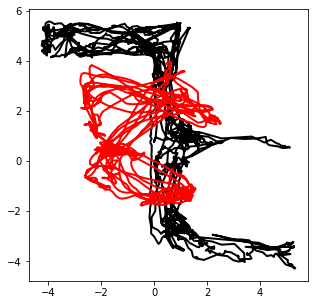

In [12]:
import funs
qz_mean_est = tt
plt.plot(qz_mean_est[:,1])
qz_est_norm = qz_mean_est#np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
#plt.plot(qz_est_norm[:,0],qz_est_norm[:,1])
z_true_c = traj# - x_test.mean(axis=0)
z_true_norm = z_true_c#/np.linalg.norm(z_true_c)

R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.figure(figsize=(14,8))
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure(figsize=(5,5))
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[:,0], qz_est_norm_R[:,1], lw=2, color = 'r')

In [13]:
#np.savetxt('lfads_k09_sim_12301628.csv', qz_est_norm_R, delimiter=',')

<IPython.core.display.Javascript object>


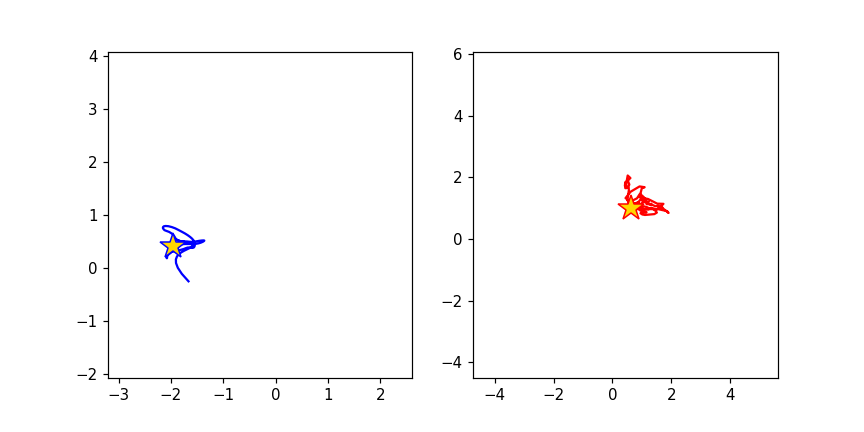

In [15]:
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
"""qz_est_norm = np.loadtxt("lfads_k09_01191015_good2.csv", 
                  delimiter=",", 
                  skiprows=0,
                  usecols=(0,1)
                 )"""
qz_est_norm[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 11, 5)
qz_est_norm[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],11, 5)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))
z_true_norm = traj
ims = []
for i in range(1000):
    x_list = []
    y_list = []
    x_list2 = []
    y_list2 = []
    for j in range(i):
        x = qz_est_norm_R[j,0]
        y = qz_est_norm_R[j,1]
        x2 = z_true_norm[j,0]
        y2 = z_true_norm[j,1]
        x_list.append(x)
        y_list.append(y)
        x_list2.append(x2)
        y_list2.append(y2)
    #print(len(x_list))
    im = ax1.plot(x_list,y_list,color='b',ls='solid', 
         marker='*',ms=18,markerfacecolor='gold',markevery=slice(i-1,i,1))
    im2 = ax2.plot(x_list2,y_list2,color='r',ls='solid', 
         marker='*',ms=18,markerfacecolor='gold',markevery=slice(i-1,i,1))
    ims.append(im+im2)

ani = animation.ArtistAnimation(fig,ims,interval=100)
plt.show()